<a href="https://colab.research.google.com/github/amousavi1/amousavi1.github.io/blob/master/USVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [24]:
def universum_svm_general(A, B, n_universum, C1=1.0, C2=1.0, epsilon=0.1):
    """
    Universum SVM for any binary classification task.

    Args:
    - A: Matrix of points for class 1 (positive class).
    - B: Matrix of points for class -1 (negative class).
    - n_universum: Number of universum points to generate.
    - C1: Regularization parameter for training data.
    - C2: Regularization parameter for universum data.
    - epsilon: Margin for universum points.

    Returns:
    - b_opt: Optimal weight vector.
    - c_opt: Optimal bias term.
    - universum_points: Generated universum points.
    """

    n_class1, n_features = A.shape
    n_class_minus_1 = B.shape[0]

    # Generate Universum points by averaging randomly selected points from both classes
    random_indices_class_1 = np.random.choice(n_class1, n_universum, replace=False)
    random_indices_class_minus_1 = np.random.choice(n_class_minus_1, n_universum, replace=False)
    universum_points = (A[random_indices_class_1] + B[random_indices_class_minus_1]) / 2

    # Combine the classes into a single dataset
    X_train = np.vstack((A, B))
    y_train = np.hstack((np.ones(n_class1), -np.ones(n_class_minus_1)))

    # Variables for optimization
    b = cp.Variable(n_features)  # We use 'b' for the weight vector
    c = cp.Variable()
    xi = cp.Variable(n_class1 + n_class_minus_1)  # Slack variables for misclassification
    psi = cp.Variable(n_universum)  # Slack variables for universum points (positive side)
    phi = cp.Variable(n_universum)  # Slack variables for universum points (negative side)

    # Constraints
    constraints = []

    # For class 1 (label +1)
    for i in range(n_class1):
        constraints.append(A[i, :] @ b + c >= 1 - xi[i])

    # For class -1 (label -1)
    for i in range(n_class_minus_1):
        constraints.append(B[i, :] @ b + c <= -1 + xi[n_class1 + i])

    # Universum constraints
    for j in range(n_universum):
        constraints.append(universum_points[j, :] @ b + c <= epsilon + psi[j])
        constraints.append(universum_points[j, :] @ b + c >= -epsilon - phi[j])

    # Non-negative slack variables
    constraints += [xi >= 0, psi >= 0, phi >= 0]

    # Objective function: minimize the sum of errors and regularization term
    objective = cp.Minimize(0.5 * cp.norm(b, 2)**2 + C1 * cp.sum(xi) + C2 * (cp.sum(psi) + cp.sum(phi)))

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Get the optimal values of b and c
    b_opt = b.value
    c_opt = c.value

    return b_opt, c_opt, universum_points

def predict(X, b, c):
    """
    Predict the labels based on the decision boundary.

    Args:
    - X: Data points.
    - b: Optimal weight vector.
    - c: Optimal bias term.

    Returns:
    - Predictions (1 or -1).
    """
    return np.sign(X @ b + c)


Accuracy: 99.50%


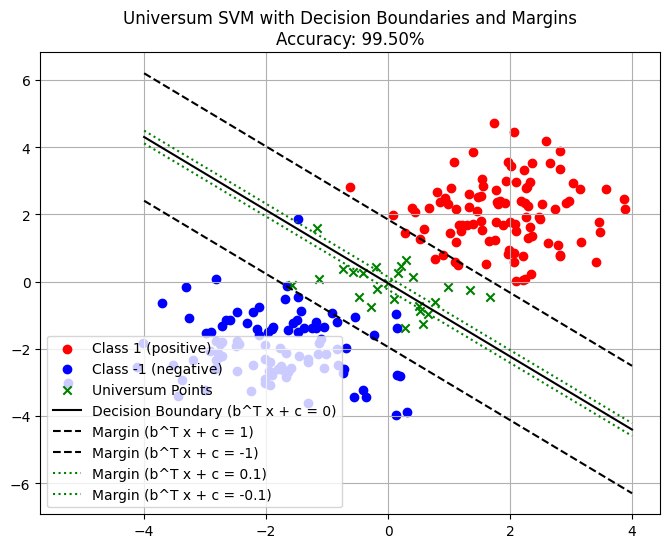

In [25]:
# Testing the Universum SVM on a specific plane geometry and compute accuracy

# Generate two classes of points
np.random.seed(42)

# Class 1 (positive class): Points from a normal distribution centered at (2, 2)
class_1 = np.random.randn(100, 2) + np.array([2, 2])

# Class -1 (negative class): Points from a normal distribution centered at (-2, -2)
class_minus_1 = np.random.randn(100, 2) + np.array([-2, -2])

# Number of universum points
n_universum = 25

# Run the Universum SVM
b_opt, c_opt, universum_points = universum_svm_general(class_1, class_minus_1, n_universum, C1=1.0, C2=1.0, epsilon=0.1)

# Combine the training data
X_train = np.vstack((class_1, class_minus_1))
y_train = np.hstack((np.ones(100), -np.ones(100)))

# Predict the labels based on the learned decision boundary
y_pred = predict(X_train, b_opt, c_opt)

# Compute the accuracy score
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Step 3: Plot the decision boundary and margins
plt.figure(figsize=(8, 6))

# Plot class 1 (positive) and class -1 (negative) points
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Class 1 (positive)')
plt.scatter(class_minus_1[:, 0], class_minus_1[:, 1], color='blue', label='Class -1 (negative)')

# Plot Universum points in green
plt.scatter(universum_points[:, 0], universum_points[:, 1], color='green', marker='x', label='Universum Points')

# Plot decision boundary: b^T x + c = 0
x_vals = np.linspace(-4, 4, 100)
decision_boundary = -(b_opt[0] * x_vals + c_opt) / b_opt[1]
plt.plot(x_vals, decision_boundary, label='Decision Boundary (b^T x + c = 0)', color='black')

# Plot margins: b^T x + c = 1 and b^T x + c = -1
margin_1 = -(b_opt[0] * x_vals + c_opt - 1) / b_opt[1]
margin_minus_1 = -(b_opt[0] * x_vals + c_opt + 1) / b_opt[1]
plt.plot(x_vals, margin_1, label='Margin (b^T x + c = 1)', linestyle='--', color='black')
plt.plot(x_vals, margin_minus_1, label='Margin (b^T x + c = -1)', linestyle='--', color='black')

# Plot Universum margins: b^T x + c = epsilon and b^T x + c = -epsilon
epsilon = 0.1
universum_margin_1 = -(b_opt[0] * x_vals + c_opt - epsilon) / b_opt[1]
universum_margin_minus_1 = -(b_opt[0] * x_vals + c_opt + epsilon) / b_opt[1]
plt.plot(x_vals, universum_margin_1, label=f'Margin (b^T x + c = {epsilon})', linestyle=':', color='green')
plt.plot(x_vals, universum_margin_minus_1, label=f'Margin (b^T x + c = {-epsilon})', linestyle=':', color='green')

# Finalize plot
plt.title(f"Universum SVM with Decision Boundaries and Margins\nAccuracy: {accuracy * 100:.2f}%")
plt.legend()
plt.grid(True)
plt.show()
